In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"hasanmoni","key":"f5fa3f523180cab359233a5780583cc7"}'}

In [2]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json  # set permission

kaggle.json


In [3]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://apache.osuosl.org/spark/spark-3.0.0/spark-3.0.0-bin-hadoop2.7.tgz
!tar xf spark-3.0.0-bin-hadoop2.7.tgz
!pip install -q findspark


In [4]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.0-bin-hadoop2.7"


##### I Completed this project on Google Colaboratory. For this I written some code in upper cell to access google colaboratory. If you run this code on your local machine you don't need upper cells!¶

### Pyspark Initialising

In [5]:
import findspark
findspark.init()

import pyspark
from pyspark import SparkContext
sc = SparkContext.getOrCreate()

#initializasing SparkSession for creating Spark DataFrame
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()


### Load Libraries

In [76]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


from pyspark.sql import SparkSession
from pyspark.sql.functions import col, sum
from pyspark.sql.types import DoubleType, IntegerType
from pyspark.sql.functions import isnan, when, count, col
from pyspark.sql.functions import rank, sum, col
from pyspark.sql.functions import mean, round
from pyspark.sql import Window
 
from sklearn.metrics import roc_curve, auc, log_loss
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import BinaryClassificationMetrics

window = Window.rowsBetween(Window.unboundedPreceding,Window.unboundedFollowing)

### Reading Dataset

In [7]:
file_type = 'text'
path=r'/content/drive/My Drive/AAA/application_train.csv'
delimeter=','

In [8]:
def load_data(file_type):
    """input type of file "text" or "parquet" and Return pyspark dataframe"""
    if file_type =="text": # use text as file type input
        df = spark.read.option("header", "true") \
                       .option("delimeter",delimeter)\
                       .option("inferSchema", "true") \
                       .csv(path)  #path file that you want import
    else:  
        df= spark.read.parquet("example.parquet") #path file that you want import
    return df

In [9]:
df = load_data(file_type)


### Initializing Dataset

In [10]:
df.show(5)


+----------+------+------------------+-----------+------------+---------------+------------+----------------+----------+-----------+---------------+---------------+----------------+--------------------+--------------------+-----------------+--------------------------+----------+-------------+-----------------+---------------+-----------+----------+--------------+---------------+----------------+----------+----------+---------------+---------------+--------------------+---------------------------+--------------------------+-----------------------+--------------------------+--------------------------+---------------------------+----------------------+----------------------+-----------------------+--------------------+-----------------+-----------------+-----------------+--------------+----------------+---------------------------+---------------+--------------+-------------+-------------+-------------+-------------+------------+--------------------+--------------+-----------------------+-

In [11]:
df.count()

307511

In [12]:
type(df)

pyspark.sql.dataframe.DataFrame

In [13]:
len(df.columns)

122

In [14]:
df.printSchema()

root
 |-- SK_ID_CURR: integer (nullable = true)
 |-- TARGET: integer (nullable = true)
 |-- NAME_CONTRACT_TYPE: string (nullable = true)
 |-- CODE_GENDER: string (nullable = true)
 |-- FLAG_OWN_CAR: string (nullable = true)
 |-- FLAG_OWN_REALTY: string (nullable = true)
 |-- CNT_CHILDREN: integer (nullable = true)
 |-- AMT_INCOME_TOTAL: double (nullable = true)
 |-- AMT_CREDIT: double (nullable = true)
 |-- AMT_ANNUITY: double (nullable = true)
 |-- AMT_GOODS_PRICE: double (nullable = true)
 |-- NAME_TYPE_SUITE: string (nullable = true)
 |-- NAME_INCOME_TYPE: string (nullable = true)
 |-- NAME_EDUCATION_TYPE: string (nullable = true)
 |-- NAME_FAMILY_STATUS: string (nullable = true)
 |-- NAME_HOUSING_TYPE: string (nullable = true)
 |-- REGION_POPULATION_RELATIVE: double (nullable = true)
 |-- DAYS_BIRTH: integer (nullable = true)
 |-- DAYS_EMPLOYED: integer (nullable = true)
 |-- DAYS_REGISTRATION: double (nullable = true)
 |-- DAYS_ID_PUBLISH: integer (nullable = true)
 |-- OWN_CAR_AG

### Dropping Unnecessary Column

In [15]:
df = df.drop('SK_ID_CURR')
df.show(5)

+------+------------------+-----------+------------+---------------+------------+----------------+----------+-----------+---------------+---------------+----------------+--------------------+--------------------+-----------------+--------------------------+----------+-------------+-----------------+---------------+-----------+----------+--------------+---------------+----------------+----------+----------+---------------+---------------+--------------------+---------------------------+--------------------------+-----------------------+--------------------------+--------------------------+---------------------------+----------------------+----------------------+-----------------------+--------------------+-----------------+-----------------+-----------------+--------------+----------------+---------------------------+---------------+--------------+-------------+-------------+-------------+-------------+------------+--------------------+--------------+-----------------------+------------

### Column Name Change

In [16]:
df_final = df.withColumnRenamed('TARGET','label')
df_final.show(5)

+-----+------------------+-----------+------------+---------------+------------+----------------+----------+-----------+---------------+---------------+----------------+--------------------+--------------------+-----------------+--------------------------+----------+-------------+-----------------+---------------+-----------+----------+--------------+---------------+----------------+----------+----------+---------------+---------------+--------------------+---------------------------+--------------------------+-----------------------+--------------------------+--------------------------+---------------------------+----------------------+----------------------+-----------------------+--------------------+-----------------+-----------------+-----------------+--------------+----------------+---------------------------+---------------+--------------+-------------+-------------+-------------+-------------+------------+--------------------+--------------+-----------------------+-------------

### Columns Name and Type

In [17]:
df_final.printSchema()


root
 |-- label: integer (nullable = true)
 |-- NAME_CONTRACT_TYPE: string (nullable = true)
 |-- CODE_GENDER: string (nullable = true)
 |-- FLAG_OWN_CAR: string (nullable = true)
 |-- FLAG_OWN_REALTY: string (nullable = true)
 |-- CNT_CHILDREN: integer (nullable = true)
 |-- AMT_INCOME_TOTAL: double (nullable = true)
 |-- AMT_CREDIT: double (nullable = true)
 |-- AMT_ANNUITY: double (nullable = true)
 |-- AMT_GOODS_PRICE: double (nullable = true)
 |-- NAME_TYPE_SUITE: string (nullable = true)
 |-- NAME_INCOME_TYPE: string (nullable = true)
 |-- NAME_EDUCATION_TYPE: string (nullable = true)
 |-- NAME_FAMILY_STATUS: string (nullable = true)
 |-- NAME_HOUSING_TYPE: string (nullable = true)
 |-- REGION_POPULATION_RELATIVE: double (nullable = true)
 |-- DAYS_BIRTH: integer (nullable = true)
 |-- DAYS_EMPLOYED: integer (nullable = true)
 |-- DAYS_REGISTRATION: double (nullable = true)
 |-- DAYS_ID_PUBLISH: integer (nullable = true)
 |-- OWN_CAR_AGE: integer (nullable = true)
 |-- FLAG_MOBIL

### Checking Null values

In [18]:
#checking Nan's value
df_final.select(*(sum(col(c).isNull().cast("int")).alias(c) for c in df_final.columns)).show()


+-----+------------------+-----------+------------+---------------+------------+----------------+----------+-----------+---------------+---------------+----------------+-------------------+------------------+-----------------+--------------------------+----------+-------------+-----------------+---------------+-----------+----------+--------------+---------------+----------------+----------+----------+---------------+---------------+--------------------+---------------------------+--------------------------+-----------------------+--------------------------+--------------------------+---------------------------+----------------------+----------------------+-----------------------+-----------------+------------+------------+------------+--------------+----------------+---------------------------+---------------+--------------+-------------+-------------+-------------+-------------+------------+--------------------+--------------+-----------------------+-----------------+---------------+

### Seperating Categorical and Numerical Columns

In [19]:
# categorical column
cat_cols = [item[0] for item in df_final.dtypes if item[1].startswith('string')] 
print("cat_cols:", cat_cols)

# numerical column
num_cols = [item[0] for item in df_final.dtypes if item[1].startswith('int') | item[1].startswith('double')] 
print("num_cols:", num_cols)


cat_cols: ['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE', 'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE']
num_cols: ['label', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'APARTMENTS_AVG', '

### Describe of Numerical columns

In [20]:
# Check summary statistic of numerical columns
df_final.select(num_cols).describe().show()

+-------+-------------------+------------------+------------------+-----------------+------------------+-----------------+--------------------------+-------------------+-----------------+------------------+-------------------+------------------+--------------------+-------------------+------------------+--------------------+-------------------+-------------------+-----------------+--------------------+---------------------------+-----------------------+--------------------------+--------------------------+---------------------------+----------------------+----------------------+-----------------------+-------------------+-------------------+------------------+-------------------+-------------------+---------------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------------+-------------------+-----------------------+--------------------+-------------------+------------------

### Checking Missing Values Again


We are using two metode to check missing values:

    1. Using pandas dataframe
    2. Using pyspark dataframe



##### Using Pandas DataFrame

In [21]:
df_pd = df_final.toPandas()

In [22]:
def missing_values_table(df_pd):
    """Input pandas dataframe and Return columns with missing value&percentage and stored as pandas dataframe"""
    mis_val = df_pd.isnull().sum() #count total of null in each columns in dataframe
    mis_val_percent = 100 * df_pd.isnull().sum() / len(df_pd) #count percentage of null in each columns
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)  #join to left (as column) between mis_val and mis_val_percent and create it as dataframe
    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0 : 'Missing Values', 1 : '% of Total Values'}) #rename columns in table, mis_val to Missing Values and mis_val_percent to % of Total Values
    mis_val_table_ren_columns = mis_val_table_ren_columns[
    mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
    '% of Total Values', ascending=False).round(1)         #sort column % of Total Values descending and round 1 after point(coma)
    print ("Your selected dataframe has " + str(df_pd.shape[1]) + " columns.\n"    #.shape[1] : just view total columns in dataframe  
    "There are " + str(mis_val_table_ren_columns.shape[0]) +              
    " columns that have missing values.") #.shape[0] : just view total rows in dataframe
    return mis_val_table_ren_columns
    

In [23]:
b=missing_values_table(df_pd)
b

Your selected dataframe has 121 columns.
There are 67 columns that have missing values.


,Missing Values,% of Total Values
COMMONAREA_MEDI,214865,69.9
COMMONAREA_AVG,214865,69.9
COMMONAREA_MODE,214865,69.9
NONLIVINGAPARTMENTS_MEDI,213514,69.4
NONLIVINGAPARTMENTS_MODE,213514,69.4
...,...,...
EXT_SOURCE_2,660,0.2
AMT_GOODS_PRICE,278,0.1
AMT_ANNUITY,12,0.0
CNT_FAM_MEMBERS,2,0.0


### Using PySpark DataFrame

In [24]:
#Check Missing Value in Pyspark Dataframe
def count_nulls(df_final):

    null_counts = []          #make an empty list to hold our results
    for col in df_final.dtypes:     #iterate through the column data types we saw above, e.g. ('C0', 'bigint')
        cname = col[0]        #splits out the column name, e.g. 'C0'    
        ctype = col[1]        #splits out the column type, e.g. 'bigint'
        nulls = df_final.where( df_final[cname].isNull() ).count() #check count of null in column name
        result = tuple([cname, nulls])  #new tuple, (column name, null count)
        null_counts.append(result)      #put the new tuple in our result list
    null_counts=[(x,y) for (x,y) in null_counts if y!=0]  #view just columns that have missing values
    return null_counts


In [25]:
#call function check missing values
null_counts = count_nulls(df_final)
null_counts


[('AMT_ANNUITY', 12),
 ('AMT_GOODS_PRICE', 278),
 ('NAME_TYPE_SUITE', 1292),
 ('OWN_CAR_AGE', 202929),
 ('OCCUPATION_TYPE', 96391),
 ('CNT_FAM_MEMBERS', 2),
 ('EXT_SOURCE_1', 173378),
 ('EXT_SOURCE_2', 660),
 ('EXT_SOURCE_3', 60965),
 ('APARTMENTS_AVG', 156061),
 ('BASEMENTAREA_AVG', 179943),
 ('YEARS_BEGINEXPLUATATION_AVG', 150007),
 ('YEARS_BUILD_AVG', 204488),
 ('COMMONAREA_AVG', 214865),
 ('ELEVATORS_AVG', 163891),
 ('ENTRANCES_AVG', 154828),
 ('FLOORSMAX_AVG', 153020),
 ('FLOORSMIN_AVG', 208642),
 ('LANDAREA_AVG', 182590),
 ('LIVINGAPARTMENTS_AVG', 210199),
 ('LIVINGAREA_AVG', 154350),
 ('NONLIVINGAPARTMENTS_AVG', 213514),
 ('NONLIVINGAREA_AVG', 169682),
 ('APARTMENTS_MODE', 156061),
 ('BASEMENTAREA_MODE', 179943),
 ('YEARS_BEGINEXPLUATATION_MODE', 150007),
 ('YEARS_BUILD_MODE', 204488),
 ('COMMONAREA_MODE', 214865),
 ('ELEVATORS_MODE', 163891),
 ('ENTRANCES_MODE', 154828),
 ('FLOORSMAX_MODE', 153020),
 ('FLOORSMIN_MODE', 208642),
 ('LANDAREA_MODE', 182590),
 ('LIVINGAPARTMENTS_MO

In [26]:
# seperating column name with null data
list_cols_miss=[x[0] for x in null_counts]
list_cols_miss

['AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'NAME_TYPE_SUITE',
 'OWN_CAR_AGE',
 'OCCUPATION_TYPE',
 'CNT_FAM_MEMBERS',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'APARTMENTS_AVG',
 'BASEMENTAREA_AVG',
 'YEARS_BEGINEXPLUATATION_AVG',
 'YEARS_BUILD_AVG',
 'COMMONAREA_AVG',
 'ELEVATORS_AVG',
 'ENTRANCES_AVG',
 'FLOORSMAX_AVG',
 'FLOORSMIN_AVG',
 'LANDAREA_AVG',
 'LIVINGAPARTMENTS_AVG',
 'LIVINGAREA_AVG',
 'NONLIVINGAPARTMENTS_AVG',
 'NONLIVINGAREA_AVG',
 'APARTMENTS_MODE',
 'BASEMENTAREA_MODE',
 'YEARS_BEGINEXPLUATATION_MODE',
 'YEARS_BUILD_MODE',
 'COMMONAREA_MODE',
 'ELEVATORS_MODE',
 'ENTRANCES_MODE',
 'FLOORSMAX_MODE',
 'FLOORSMIN_MODE',
 'LANDAREA_MODE',
 'LIVINGAPARTMENTS_MODE',
 'LIVINGAREA_MODE',
 'NONLIVINGAPARTMENTS_MODE',
 'NONLIVINGAREA_MODE',
 'APARTMENTS_MEDI',
 'BASEMENTAREA_MEDI',
 'YEARS_BEGINEXPLUATATION_MEDI',
 'YEARS_BUILD_MEDI',
 'COMMONAREA_MEDI',
 'ELEVATORS_MEDI',
 'ENTRANCES_MEDI',
 'FLOORSMAX_MEDI',
 'FLOORSMIN_MEDI',
 'LANDAREA_MEDI',
 'LIVINGAPARTMENTS_MEDI',

In [27]:
#Create dataframe which just has list_cols_miss
df_miss= df_final.select(*list_cols_miss)

#view data types in df_miss
df_miss.dtypes

[('AMT_ANNUITY', 'double'),
 ('AMT_GOODS_PRICE', 'double'),
 ('NAME_TYPE_SUITE', 'string'),
 ('OWN_CAR_AGE', 'int'),
 ('OCCUPATION_TYPE', 'string'),
 ('CNT_FAM_MEMBERS', 'int'),
 ('EXT_SOURCE_1', 'double'),
 ('EXT_SOURCE_2', 'double'),
 ('EXT_SOURCE_3', 'double'),
 ('APARTMENTS_AVG', 'double'),
 ('BASEMENTAREA_AVG', 'double'),
 ('YEARS_BEGINEXPLUATATION_AVG', 'double'),
 ('YEARS_BUILD_AVG', 'double'),
 ('COMMONAREA_AVG', 'double'),
 ('ELEVATORS_AVG', 'double'),
 ('ENTRANCES_AVG', 'double'),
 ('FLOORSMAX_AVG', 'double'),
 ('FLOORSMIN_AVG', 'double'),
 ('LANDAREA_AVG', 'double'),
 ('LIVINGAPARTMENTS_AVG', 'double'),
 ('LIVINGAREA_AVG', 'double'),
 ('NONLIVINGAPARTMENTS_AVG', 'double'),
 ('NONLIVINGAREA_AVG', 'double'),
 ('APARTMENTS_MODE', 'double'),
 ('BASEMENTAREA_MODE', 'double'),
 ('YEARS_BEGINEXPLUATATION_MODE', 'double'),
 ('YEARS_BUILD_MODE', 'double'),
 ('COMMONAREA_MODE', 'double'),
 ('ELEVATORS_MODE', 'double'),
 ('ENTRANCES_MODE', 'double'),
 ('FLOORSMAX_MODE', 'double'),
 ('F

### Categorical and Numerical columns of missing columns 

In [28]:
### for categorical columns
catcolums_miss=[item[0] for item in df_miss.dtypes if item[1].startswith('string')]  #will select name of column with string data type
print("catcolums_miss:", catcolums_miss)

### for numerical columns
numcolumns_miss = [item[0] for item in df_miss.dtypes if item[1].startswith('int') | item[1].startswith('double')] #will select name of column with integer or double data type
print("numcolumns_miss:", numcolumns_miss)


catcolums_miss: ['NAME_TYPE_SUITE', 'OCCUPATION_TYPE', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE']
numcolumns_miss: ['AMT_ANNUITY', 'AMT_GOODS_PRICE', 'OWN_CAR_AGE', 'CNT_FAM_MEMBERS', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'ELEVATORS_AVG', 'ENTRANCES_AVG', 'FLOORSMAX_AVG', 'FLOORSMIN_AVG', 'LANDAREA_AVG', 'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG', 'NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAREA_AVG', 'APARTMENTS_MODE', 'BASEMENTAREA_MODE', 'YEARS_BEGINEXPLUATATION_MODE', 'YEARS_BUILD_MODE', 'COMMONAREA_MODE', 'ELEVATORS_MODE', 'ENTRANCES_MODE', 'FLOORSMAX_MODE', 'FLOORSMIN_MODE', 'LANDAREA_MODE', 'LIVINGAPARTMENTS_MODE', 'LIVINGAREA_MODE', 'NONLIVINGAPARTMENTS_MODE', 'NONLIVINGAREA_MODE', 'APARTMENTS_MEDI', 'BASEMENTAREA_MEDI', 'YEARS_BEGINEXPLUATATION_MEDI', 'YEARS_BUILD_MEDI', 'COMMONAREA_MEDI', 'ELEVATORS_MEDI', 'ENTRANCES_MEDI', 'FLOO

### Filling Missing Values

In [29]:
df_Nomiss=df_final.na.drop()

In [30]:
for x in catcolums_miss:                  
    mode=df_Nomiss.groupBy(x).count().sort(col("count").desc()).collect()[0][0] 
    print(x, mode) #print name of columns and it's most categories 
    
    df_final = df_final.na.fill({x:mode})
    # and we fill the missing numerical values with the average of each 
    #column
    
for i in numcolumns_miss:
    meanvalue = df_Nomiss.select(round(mean(i))).collect()[0][0] 
    print(i, meanvalue) 
    df_final=df_final.na.fill({i:meanvalue})


NAME_TYPE_SUITE Unaccompanied
OCCUPATION_TYPE Laborers
FONDKAPREMONT_MODE reg oper account
HOUSETYPE_MODE block of flats
WALLSMATERIAL_MODE Panel
EMERGENCYSTATE_MODE No
AMT_ANNUITY 31559.0
AMT_GOODS_PRICE 633834.0
OWN_CAR_AGE 11.0
CNT_FAM_MEMBERS 2.0
EXT_SOURCE_1 0.0
EXT_SOURCE_2 1.0
EXT_SOURCE_3 0.0
APARTMENTS_AVG 0.0
BASEMENTAREA_AVG 0.0
YEARS_BEGINEXPLUATATION_AVG 1.0
YEARS_BUILD_AVG 1.0
COMMONAREA_AVG 0.0
ELEVATORS_AVG 0.0
ENTRANCES_AVG 0.0
FLOORSMAX_AVG 0.0
FLOORSMIN_AVG 0.0
LANDAREA_AVG 0.0
LIVINGAPARTMENTS_AVG 0.0
LIVINGAREA_AVG 0.0
NONLIVINGAPARTMENTS_AVG 0.0
NONLIVINGAREA_AVG 0.0
APARTMENTS_MODE 0.0
BASEMENTAREA_MODE 0.0
YEARS_BEGINEXPLUATATION_MODE 1.0
YEARS_BUILD_MODE 1.0
COMMONAREA_MODE 0.0
ELEVATORS_MODE 0.0
ENTRANCES_MODE 0.0
FLOORSMAX_MODE 0.0
FLOORSMIN_MODE 0.0
LANDAREA_MODE 0.0
LIVINGAPARTMENTS_MODE 0.0
LIVINGAREA_MODE 0.0
NONLIVINGAPARTMENTS_MODE 0.0
NONLIVINGAREA_MODE 0.0
APARTMENTS_MEDI 0.0
BASEMENTAREA_MEDI 0.0
YEARS_BEGINEXPLUATATION_MEDI 1.0
YEARS_BUILD_MEDI 1.0


### checking missing value again

In [31]:
df_final.select(*(sum(col(c).isNull().cast("int")).alias(c) for c in df_final.columns)).show()

+-----+------------------+-----------+------------+---------------+------------+----------------+----------+-----------+---------------+---------------+----------------+-------------------+------------------+-----------------+--------------------------+----------+-------------+-----------------+---------------+-----------+----------+--------------+---------------+----------------+----------+----------+---------------+---------------+--------------------+---------------------------+--------------------------+-----------------------+--------------------------+--------------------------+---------------------------+----------------------+----------------------+-----------------------+-----------------+------------+------------+------------+--------------+----------------+---------------------------+---------------+--------------+-------------+-------------+-------------+-------------+------------+--------------------+--------------+-----------------------+-----------------+---------------+

##### Yeap! There are no missing values

### Exploratory Data Analysis

In [32]:
df_pd = df_final.toPandas()

##### Categorical Variables

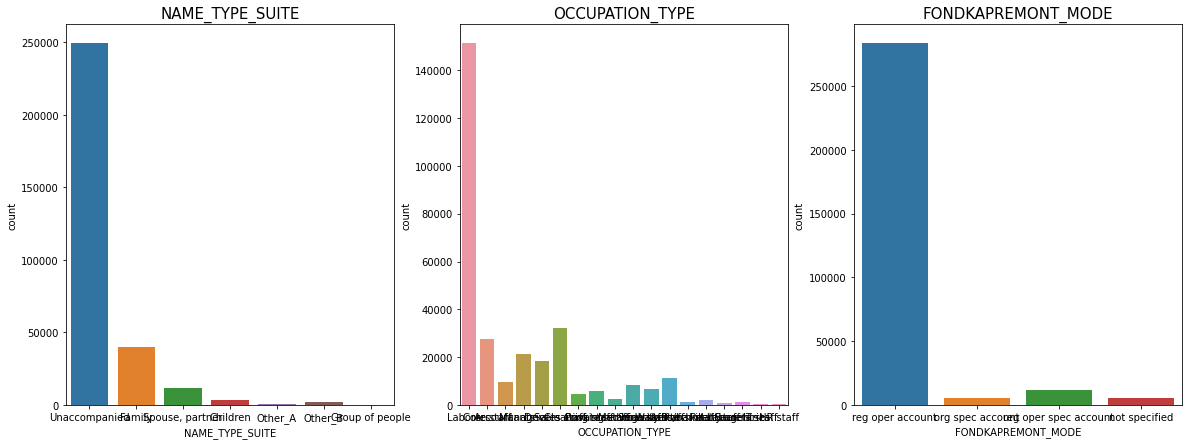

In [33]:
plt.figure(figsize=(20,7))
plt.subplot(131)
sns.countplot(x='NAME_TYPE_SUITE', data=df_pd)
plt.title('NAME_TYPE_SUITE', fontsize=15)
plt.subplot(132)
sns.countplot(x='OCCUPATION_TYPE', data=df_pd)
plt.title('OCCUPATION_TYPE', fontsize=15)
plt.subplot(133)
sns.countplot(x='FONDKAPREMONT_MODE', data=df_pd)
plt.title('FONDKAPREMONT_MODE', fontsize=15)
plt.show()


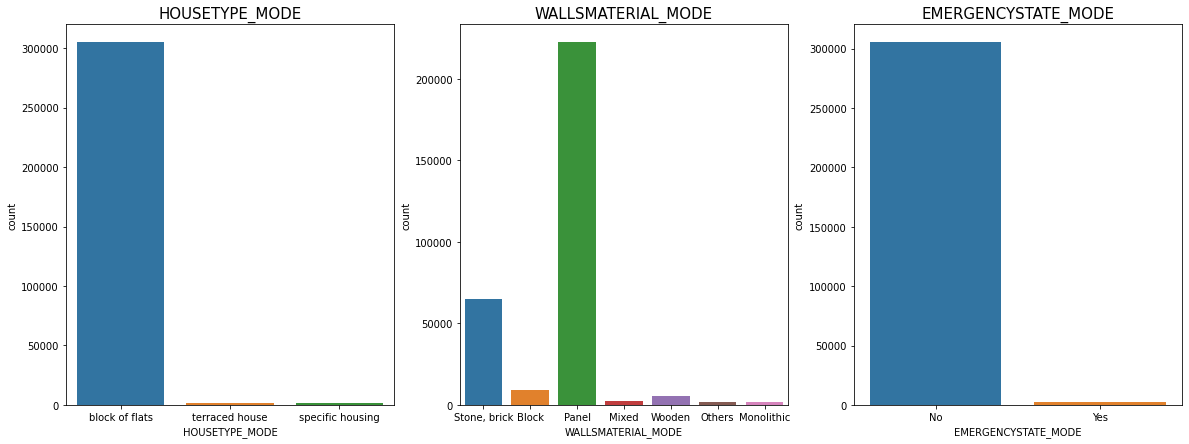

In [34]:
plt.figure(figsize=(20,7))
plt.subplot(131)
sns.countplot(x='HOUSETYPE_MODE', data=df_pd)
plt.title('HOUSETYPE_MODE', fontsize=15)
plt.subplot(132)
sns.countplot(x='WALLSMATERIAL_MODE', data=df_pd)
plt.title('WALLSMATERIAL_MODE', fontsize=15)
plt.subplot(133)
sns.countplot(x='EMERGENCYSTATE_MODE', data=df_pd)
plt.title('EMERGENCYSTATE_MODE', fontsize=15)
plt.show()


##### Numerical Variables

##### Here have so many numerical variables. For this I am going to visualize some of them

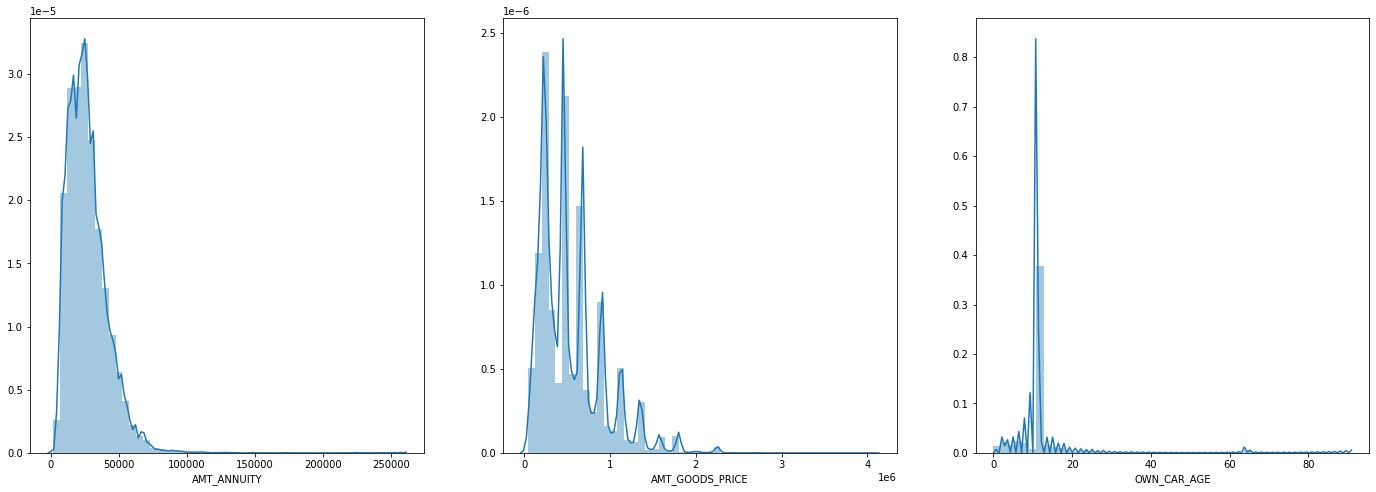

In [35]:
#distribusi of AMT_ANNUITY, AMT_GOODS_PRICE and OWN_CAR_AGE
plt.figure(figsize=(24,8))
plt.subplot(131)
sns.distplot(df_pd['AMT_ANNUITY'])
plt.subplot(132)
sns.distplot(df_pd['AMT_GOODS_PRICE'])
plt.subplot(133)
sns.distplot(df_pd['OWN_CAR_AGE'])
plt.show()


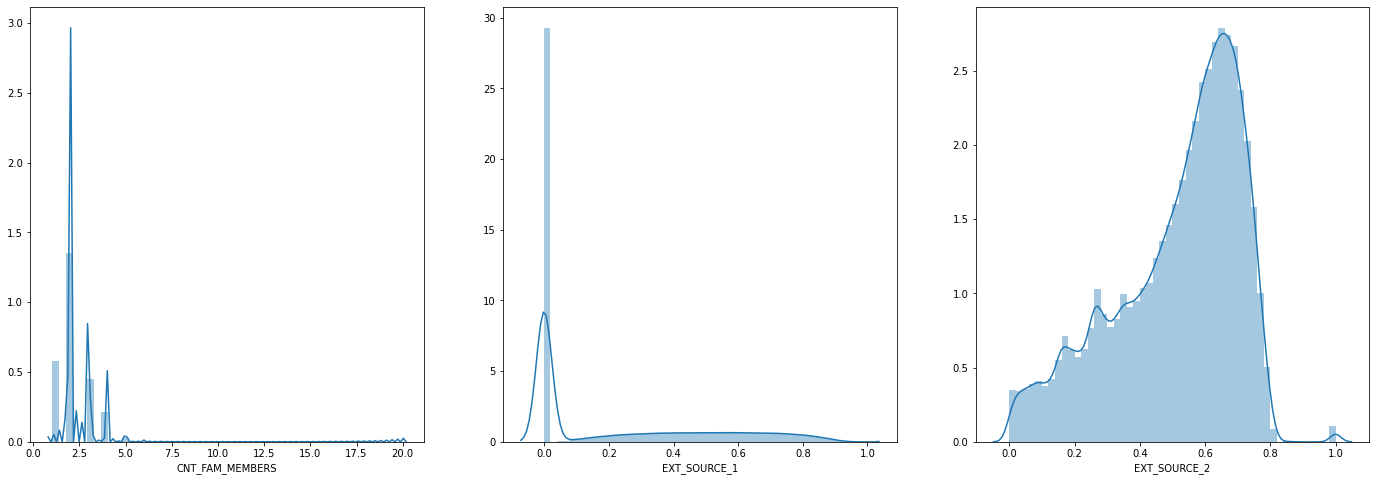

In [36]:
#distribusi of CNT_FAM_MEMBERS, EXT_SOURCE_1 and EXT_SOURCE_2
plt.figure(figsize=(24,8))
plt.subplot(131)
sns.distplot(df_pd['CNT_FAM_MEMBERS'])
plt.subplot(132)
sns.distplot(df_pd['EXT_SOURCE_1'])
plt.subplot(133)
sns.distplot(df_pd['EXT_SOURCE_2'])
plt.show()


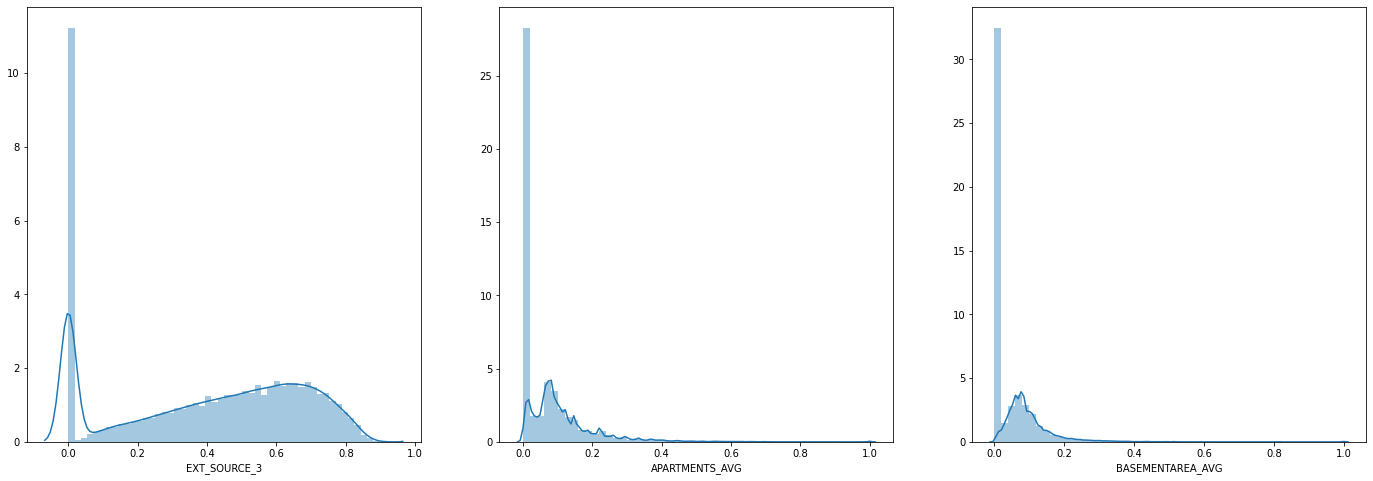

In [37]:
#distribusi of EXT_SOURCE_3, APARTMENTS_AVG and BASEMENTAREA_AVG
plt.figure(figsize=(24,8))
plt.subplot(131)
sns.distplot(df_pd['EXT_SOURCE_3'])
plt.subplot(132)
sns.distplot(df_pd['APARTMENTS_AVG'])
plt.subplot(133)
sns.distplot(df_pd['BASEMENTAREA_AVG'])
plt.show()

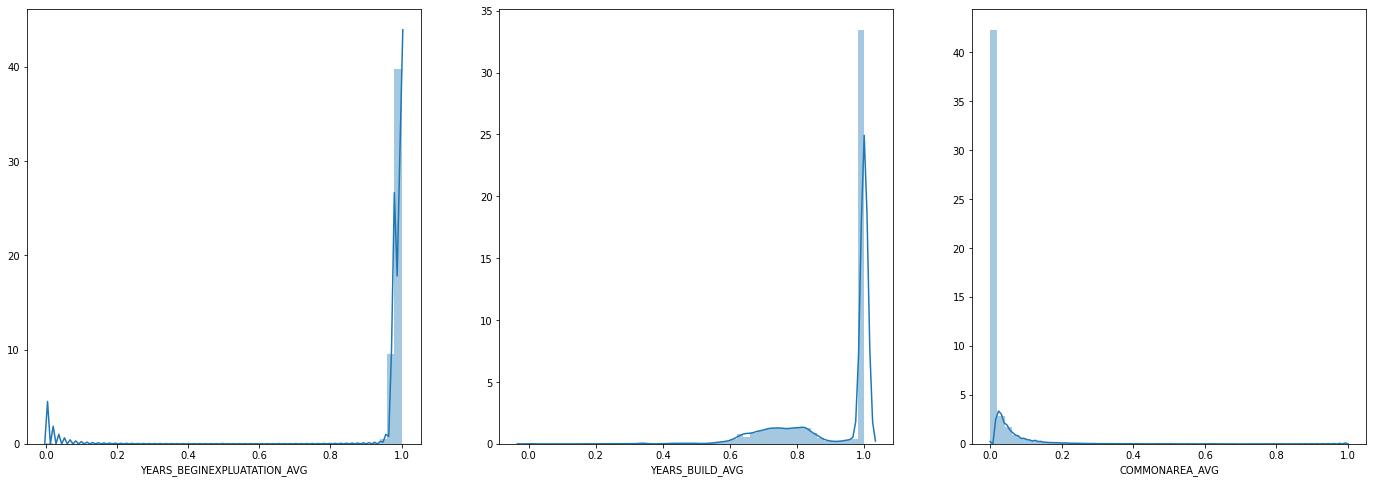

In [38]:
#distribusi of YEARS_BEGINEXPLUATATION_AVG, YEARS_BUILD_AVG and COMMONAREA_AVG
plt.figure(figsize=(24,8))
plt.subplot(131)
sns.distplot(df_pd['YEARS_BEGINEXPLUATATION_AVG'])
plt.subplot(132)
sns.distplot(df_pd['YEARS_BUILD_AVG'])
plt.subplot(133)
sns.distplot(df_pd['COMMONAREA_AVG'])
plt.show()

### Replacing Insignificant Categories

In [39]:
df_percent=df_final.groupBy('NAME_TYPE_SUITE').count().sort(col("count").desc())\
                    .withColumn('total',sum(col('count')).over(window))\
                    .withColumn('Percent',col('count')*100/col('total')) #calculate the percentage-save in Percent columns from each categories
df_percent.show()


+---------------+------+------+-------------------+
|NAME_TYPE_SUITE| count| total|            Percent|
+---------------+------+------+-------------------+
|  Unaccompanied|249818|307511|  81.23871991571033|
|         Family| 40149|307511| 13.056118317718715|
|Spouse, partner| 11370|307511| 3.6974287098672893|
|       Children|  3267|307511| 1.0624010198009177|
|        Other_B|  1770|307511|  0.575589165916016|
|        Other_A|   866|307511|0.28161594219393776|
|Group of people|   271|307511|0.08812692879279115|
+---------------+------+------+-------------------+



In [40]:
threshold=97
threshold2=0.7


In [41]:
def replace_cat2(f,cols):
    """input are dataframe and categorical variables, replace insignificant categories (percentage <=0.7) with largest number
    of catgories and output is new dataframe """
    df_percent=f.groupBy(cols).count().sort(col("count").desc())\
                .withColumn('total',sum(col('count')).over(window))\
                .withColumn('Percent',col('count')*100/col('total')) 
    dominant_cat=df_percent.select(df_percent['Percent']).collect()[0][0] 
    count_dist=f.select([cols]).distinct().count() 
    if count_dist > 2 and dominant_cat <= threshold :
        print('column:', cols)
        cols_names.append(cols) 
        replacement=f.groupBy(cols).count().sort(col("count").desc()).collect()[0][0] 
        print("replacement:",replacement)
        replacing.append(replacement)
        insign_cat=df_percent.filter(df_percent['Percent']< threshold2).select(df_percent[cols]).collect() 
        insign_cat=[r[cols] for r in insign_cat] 
        category.append(insign_cat) 
        print("insign_cat:",insign_cat)
        f=f.replace(insign_cat,replacement, cols) 
    return f


In [42]:
#call function replacing insignificant categories 
replacing=[]
cols_names=[]
category=[]
for cols in cat_cols:
    df_final=replace_cat2(df_final,cols)
    

column: CODE_GENDER
replacement: F
insign_cat: ['XNA']
column: NAME_TYPE_SUITE
replacement: Unaccompanied
insign_cat: ['Other_B', 'Other_A', 'Group of people']
column: NAME_INCOME_TYPE
replacement: Working
insign_cat: ['Unemployed', 'Student', 'Businessman', 'Maternity leave']
column: NAME_EDUCATION_TYPE
replacement: Secondary / secondary special
insign_cat: ['Academic degree']
column: NAME_FAMILY_STATUS
replacement: Married
insign_cat: ['Unknown']
column: NAME_HOUSING_TYPE
replacement: House / apartment
insign_cat: ['Co-op apartment']
column: OCCUPATION_TYPE
replacement: Laborers
insign_cat: ['Low-skill Laborers', 'Waiters/barmen staff', 'Secretaries', 'Realty agents', 'HR staff', 'IT staff']
column: WEEKDAY_APPR_PROCESS_START
replacement: TUESDAY
insign_cat: []
column: ORGANIZATION_TYPE
replacement: Business Entity Type 3
insign_cat: ['Security Ministries', 'Trade: type 2', 'Restaurant', 'Services', 'University', 'Industry: type 7', 'Transport: type 3', 'Industry: type 1', 'Hotel', '

In [43]:
#check length in list cols_names, category and replacing
len(cols_names), len(category), len(replacing)


(11, 11, 11)

In [44]:
#Create dataframe of replaced categories
g=spark.createDataFrame(list(zip(cols_names, replacing, category)),['cols_names', 'replacing', 'category'])
g.show(10)


+--------------------+--------------------+--------------------+
|          cols_names|           replacing|            category|
+--------------------+--------------------+--------------------+
|         CODE_GENDER|                   F|               [XNA]|
|     NAME_TYPE_SUITE|       Unaccompanied|[Other_B, Other_A...|
|    NAME_INCOME_TYPE|             Working|[Unemployed, Stud...|
| NAME_EDUCATION_TYPE|Secondary / secon...|   [Academic degree]|
|  NAME_FAMILY_STATUS|             Married|           [Unknown]|
|   NAME_HOUSING_TYPE|   House / apartment|   [Co-op apartment]|
|     OCCUPATION_TYPE|            Laborers|[Low-skill Labore...|
|WEEKDAY_APPR_PROC...|             TUESDAY|                  []|
|   ORGANIZATION_TYPE|Business Entity T...|[Security Ministr...|
|  FONDKAPREMONT_MODE|    reg oper account|                  []|
+--------------------+--------------------+--------------------+
only showing top 10 rows



In [45]:
g.dtypes


[('cols_names', 'string'),
 ('replacing', 'string'),
 ('category', 'array<string>')]

In [46]:
g.printSchema()

root
 |-- cols_names: string (nullable = true)
 |-- replacing: string (nullable = true)
 |-- category: array (nullable = true)
 |    |-- element: string (containsNull = true)



In [47]:
f_percent=df_final.groupBy('OCCUPATION_TYPE').count().sort(col("count").desc())\
                       .withColumn('total',sum(col('count')).over(window))\
                       .withColumn('Percent',col('count')*100/col('total'))

f_percent.show()


+--------------------+------+------+------------------+
|     OCCUPATION_TYPE| count| total|           Percent|
+--------------------+------+------+------------------+
|            Laborers|158163|307511| 51.43328206145471|
|         Sales staff| 32102|307511|10.439301358325393|
|          Core staff| 27570|307511| 8.965532940285064|
|            Managers| 21371|307511| 6.949670093102361|
|             Drivers| 18603|307511| 6.049539691263076|
|High skill tech s...| 11380|307511|3.7006806260589054|
|         Accountants|  9813|307511|3.1911053588326923|
|      Medicine staff|  8537|307511| 2.776160852782502|
|      Security staff|  6721|307511| 2.185612872385053|
|       Cooking staff|  5946|307511|  1.93358936753482|
|      Cleaning staff|  4653|307511|1.5131166039588828|
|Private service s...|  2652|307511|0.8624081740165392|
+--------------------+------+------+------------------+



### Handling Outlier

In [ ]:
#create quantile dataframe
def quantile(e):
    """Input is dataframe and return new dataframe with value of quantile from numerical columns"""
    percentiles = [0.25, 0.5, 0.75]
    quant=spark.createDataFrame(zip(percentiles, *e.approxQuantile(num_cols, percentiles, 0.0)),
                               ['percentile']+num_cols) #calculate quantile from pyspark dataframe, 0.0 is relativeError,
                                                        #The relative target precision to achieve (>= 0). If set to zero, 
                                                        #the exact quantiles are computed, which could be very expensive
                                                        #and aggregate the result with percentiles variable, 
                                                        #then create pyspark dataframe
    return quant


In [55]:
#call function quantile
quantile=quantile(df_final)


In [ ]:
#function to calculate uppler side
def upper_value(b,c):
    """Input is quantile dataframe and name of numerical column and Retrun upper value from the column"""
    q1 = b.select(c).collect()[0][0] #select value of q1 from the column
    q2 = b.select(c).collect()[1][0] #select value of q2 from the column
    q3 = b.select(c).collect()[2][0] #select value of q3 from the column
    IQR=q3-q1  #calculate the value of IQR
    upper= q3 + (IQR*1.5)   #calculate the value of upper side
    return upper


#function to calculate lower side
def lower_value(b,c):
    """Input is quantile dataframe and name of numerical column and Retrun lower value from the column"""
    q1 = b.select(c).collect()[0][0] #select value of q1 from the column
    q2 = b.select(c).collect()[1][0] #select value of q2 from the column
    q3 = b.select(c).collect()[2][0] #select value of q3 from the column
    IQR=q3-q1                   #calculate the value of IQR
    lower= q1 - (IQR*1.5)       #calculate the value of lower side
    return lower
    

##### Replacing the outlier

In [ ]:
#function for replacing outlier by upper side
def replce_outlier_up2(d,col, value):
    """Input is name of numerical column and it's upper side value"""
    #global d
    d=d.withColumn(col, F.when(d[col] > value , value).otherwise(d[col]))
    return d


#function for replacing outlier by lower side
def replce_outlier_low2(d,col, value):
    """Input is name of numerical column and it's lower side value"""
    #global df_final
    d=d.withColumn(col, F.when(d[col] < value , value).otherwise(d[col]))
    return d

In [ ]:
#call function to calculate lower side and replace value under lower side with value lower side
for i in num_cols:
    lower=lower_value(quantile,i)
    df_final=replce_outlier_low2(df_final, i, lower)


#call function to calculate upper side and replace value above upper side with value upper side
for x in num_cols:
    upper=upper_value(quantile,x)
    df_final=replce_outlier_up2(df_final, x, upper)
    

In [50]:
df_final.columns

['label',
 'NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'NAME_TYPE_SUITE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'REGION_POPULATION_RELATIVE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'OWN_CAR_AGE',
 'FLAG_MOBIL',
 'FLAG_EMP_PHONE',
 'FLAG_WORK_PHONE',
 'FLAG_CONT_MOBILE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'OCCUPATION_TYPE',
 'CNT_FAM_MEMBERS',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'WEEKDAY_APPR_PROCESS_START',
 'HOUR_APPR_PROCESS_START',
 'REG_REGION_NOT_LIVE_REGION',
 'REG_REGION_NOT_WORK_REGION',
 'LIVE_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'LIVE_CITY_NOT_WORK_CITY',
 'ORGANIZATION_TYPE',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'APARTMENTS_AVG',
 'BASEMENTAREA_AVG',
 'YEARS_BEGINEXPLUATATION_AVG',
 'YEARS_BUI

### Encoding

In [51]:
stages = []
for categoricalCol in cat_cols:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    stages += [stringIndexer, encoder]
    
assemblerInputs = [c + "classVec" for c in cat_cols] + num_cols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]


### Pipeline

In [52]:
cols = df_final.columns
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(df_final)
df_final = pipelineModel.transform(df_final)

selectedCols = ['features']+cols
df_final = df_final.select(selectedCols)
pd.DataFrame(df_final.take(5), columns=df_final.columns)


,features,label,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,...,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,"(1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, ...",1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,11,1,1,0,1,1,0,Laborers,1,2,2,WEDNESDAY,10,0,0,0,0,0,0,...,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2,2,2,2,-1134,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,"(1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,11,1,1,0,1,1,0,Core staff,2,1,1,MONDAY,11,0,0,0,0,0,0,...,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1,0,1,0,-828,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,"(0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, ...",0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26,1,1,1,1,1,0,Laborers,1,2,2,MONDAY,9,0,0,0,0,0,0,...,0.0000,0.0000,0.0000,0.00,reg oper account,block of flats,0.0000,Panel,No,0,0,0,0,-815,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,"(1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, ...",0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,0.008019,-19005,-3039,-9833.0,-2437,11,1,1,0,1,0,0,Laborers,2,2,2,WEDNESDAY,17,0,0,0,0,0,0,...,0.0000,0.0000,0.0000,0.00,reg oper account,block of flats,0.0000,Panel,No,2,0,2,0,-617,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
4,"(1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, ...",0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.028663,-19932,-3038,-4311.0,-3458,11,1,1,0,1,0,0,Core staff,1,2,2,THURSDAY,11,0,0,0,0,1,1,...,0.0000,0.0000,0.0000,0.00,reg oper account,block of flats,0.0000,Panel,No,0,0,0,0,-1106,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Selecting only Features and Label

In [53]:
df_final.select('features', 'label').show(5)

+--------------------+-----+
|            features|label|
+--------------------+-----+
|(177,[0,2,3,4,7,1...|    1|
|(177,[0,1,2,5,11,...|    0|
|(177,[3,4,7,10,14...|    0|
|(177,[0,1,2,3,4,7...|    0|
|(177,[0,2,3,4,7,1...|    0|
+--------------------+-----+
only showing top 5 rows



### Split Dataset

In [54]:
data_train, data_test=df_final.randomSplit([0.7,0.3], 24)


In [92]:
data_train.count()

215675

In [93]:
data_test.count()

91836

### Modeling and Evaluation


##### Modelling

We will use four algorithm to make a model and prediction, they are:

1. Logistic Regression Logistic regression used logit function in prediction the probability.

4. Gradient Boosting This algorithm use boosting ensemble technic. This technique employs the logic in which the subsequent predictors learn from the mistakes of the previous predictors.

##### Evaluation

To evaluate model we use metrics, below:

1. RMSE (Root Mean Square Error) RMSE measures the differences between predicted values by the model and the actual values. RMSE can also state the size of the error generated by a prediction model.

2. R2 or R squared R-squared is a statistical measure of how close the data are to the fitted regression line. R-squared is always between 0 and 100%:
    i) 0% indicates that the model explains none of the variability of the response data around its mean.
    ii) 100% indicates that the model explains all the variability of the response data around its mean.



##### Logistic Regression

In [55]:
#define logistic regression model
lr_hyper=LogisticRegression(featuresCol='features', labelCol='label')


#Hyper-Parameter Tuning
paramGrid_lr = ParamGridBuilder() \
    .addGrid(lr_hyper.regParam, [0.1, 0.01]) \
    .addGrid(lr_hyper.elasticNetParam, [0.8, 0.7]) \
    .build()
crossval_lr = CrossValidator(estimator=lr_hyper,
                             estimatorParamMaps=paramGrid_lr,
                             evaluator=BinaryClassificationEvaluator(),
                             numFolds=3)
#fit model to data train
lr_model_hyper = crossval_lr.fit(data_train)


In [56]:
#Transform model to data test
lr_result_hyper = lr_model_hyper.transform(data_test)

In [57]:
#view id, label, prediction and probability from result of modelling
lr_result_hyper.select('label', 'prediction', 'probability').show(5)

+-----+----------+--------------------+
|label|prediction|         probability|
+-----+----------+--------------------+
|    1|       1.0|[0.34558184257459...|
|    1|       1.0|[0.34558184257459...|
|    1|       1.0|[0.34558184257459...|
|    1|       1.0|[0.34558184257459...|
|    1|       1.0|[0.34558184257459...|
+-----+----------+--------------------+
only showing top 5 rows



##### Logistic Regression With Hyper-Parameter Tuning Evaluation

In [60]:
#Evaluate model by checking accuracy and AUC value
lr_hyper_eval = BinaryClassificationEvaluator(rawPredictionCol="probability", labelCol="label")
lr_hyper_eval2= MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="label")
lr_hyper_AUC  = lr_hyper_eval.evaluate(lr_result_hyper)
lr_hyper_ACC  = lr_hyper_eval2.evaluate(lr_result_hyper, {lr_hyper_eval2.metricName:"accuracy"})

print("Logistic Regression Performance Measure")
print("Accuracy = %0.2f" % lr_hyper_ACC)
print("AUC = %.2f" % lr_hyper_AUC)


Logistic Regression Performance Measure
Accuracy = 1.00
AUC = 1.00


##### ROC Curbe

Logistic Regression Area Under ROC
Area under ROC = 1.00


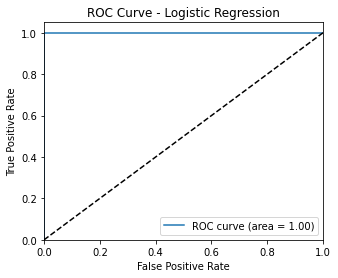

In [66]:
PredAndLabels           = lr_result_hyper.select("probability", "label")
PredAndLabels_collect   = PredAndLabels.collect()
PredAndLabels_list      = [(float(i[0][0]), 1.0-float(i[1])) for i in PredAndLabels_collect]
PredAndLabels           = sc.parallelize(PredAndLabels_list)

metrics = BinaryClassificationMetrics(PredAndLabels)

# Area under ROC
print("Logistic Regression Area Under ROC")
print("Area under ROC = %.2f" % metrics.areaUnderROC)

# Visualization
FPR = dict()                                                        # FPR: False Positive Rate
tpr = dict()                                                        # TPR: True Positive Rate
roc_auc = dict()
 
y_test = [i[1] for i in PredAndLabels_list]
y_score = [i[0] for i in PredAndLabels_list]
 
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)
 
plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression')
plt.legend(loc="lower right")
plt.show()


##### Confusion Matrix

In [67]:
cm_lr_result_hyper = lr_result_hyper.crosstab("prediction", "label")
cm_lr_result_hyper = cm_lr_result_hyper.toPandas()
cm_lr_result_hyper


,prediction_label,0,1
0,1.0,0,7433
1,0.0,84403,0


In [68]:
#calculate Accuracy, Sensitivity, Specificity, Precision
TP = cm_lr_result_hyper["1"][0]
FP = cm_lr_result_hyper["0"][0]
TN = cm_lr_result_hyper["0"][1]
FN = cm_lr_result_hyper["1"][1]
Accuracy = (TP+TN)/(TP+FP+TN+FN)
Sensitivity = TP/(TP+FN)
Specificity = TN/(TN+FP)
Precision = TP/(TP+FP)

print ("Accuracy = %0.2f" %Accuracy )
print ("Sensitivity = %0.2f" %Sensitivity )
print ("Specificity = %0.2f" %Specificity )
print ("Precision = %0.2f" %Precision )


Accuracy = 1.00
Sensitivity = 1.00
Specificity = 1.00
Precision = 1.00


##### Calculate Gini Coefisient from AUC

In [69]:
AUC = lr_hyper_AUC
Gini_lr_hyper = (2 * AUC - 1)
print("AUC=%.2f" % AUC)
print("GINI ~=%.2f" % Gini_lr_hyper)


AUC=1.00
GINI ~=1.00


##### Calculate Log Loss in pandas dataframe

In [71]:
#Create Dataframe to Calculate Log Loss
y_test= data_test.select('label')
lr_hyper_proba=lr_result_hyper.select('probability')

In [74]:
#Convert lr_probaspark dataframe to numpy array
lr_hyper_proba= np.array(lr_hyper_proba.select('probability').collect())

#Convert numpy array 3 dimentional to 2 dimentional
lr_hyper_proba=lr_hyper_proba.reshape(-1, lr_hyper_proba.shape[-1])

#Convert y_test dataframe to pandas dataframe
y_test=y_test.toPandas()

#Convert y_test pandas dataframe to pandas series
y_test=pd.Series(y_test['label'].values)


In [78]:
#Calculate log loss from logistic regression hyper parameter
LogLoss = log_loss(y_test, lr_hyper_proba) 

print("Log Loss Logistic Regression:%.4f" % LogLoss)


Log Loss Logistic Regression:0.0626


### Gradient Boosting

In [79]:
#define gradient boosting model
gbt_hyper= GBTClassifier(featuresCol="features", labelCol="label")

# Hyper-Parameter Tuning
paramGrid_gbt = ParamGridBuilder() \
    .addGrid(gbt_hyper.maxIter, [10])\
    .addGrid(gbt_hyper.maxDepth, [6, 7,10]) \
    .build()
crossval_gbt = CrossValidator(estimator=gbt_hyper,
                             estimatorParamMaps=paramGrid_gbt,
                             evaluator=BinaryClassificationEvaluator(),
                             numFolds=3)
#fit model to data train
gbt_model_hyper = crossval_gbt.fit(data_train)


In [80]:
#transfrom model to data test
gbt_result_hyper = gbt_model_hyper.transform(data_test)


In [82]:
#view id, label, prediction and probability from result of modelling
gbt_result_hyper.select('label', 'prediction', 'probability').show(5)


+-----+----------+--------------------+
|label|prediction|         probability|
+-----+----------+--------------------+
|    1|       1.0|[0.06587782434721...|
|    1|       1.0|[0.06587782434721...|
|    1|       1.0|[0.06587782434721...|
|    1|       1.0|[0.06587782434721...|
|    1|       1.0|[0.06587782434721...|
+-----+----------+--------------------+
only showing top 5 rows



##### Gradient Boosting With Hyper-Parameter Evaluation

In [83]:
#Evaluate model by calculating accuracy and area under curve (AUC)
gbt_eval_hyper = BinaryClassificationEvaluator(rawPredictionCol="probability", labelCol="label")
gbt_eval_hyper2= MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="label")
gbt_hyper_AUC  = gbt_eval_hyper.evaluate(gbt_result_hyper)
gbt_hyper_ACC  = gbt_eval_hyper2.evaluate(gbt_result_hyper, {gbt_eval_hyper2.metricName:"accuracy"})


print("Gradient Boosted Tree Performance Measure")
print("Accuracy = %0.2f" % gbt_hyper_ACC)
print("AUC = %.2f" % gbt_hyper_AUC)

Gradient Boosted Tree Performance Measure
Accuracy = 1.00
AUC = 1.00


##### ROC Curbe

Gradient Boosting Area Under ROC
Area under ROC = 1.00


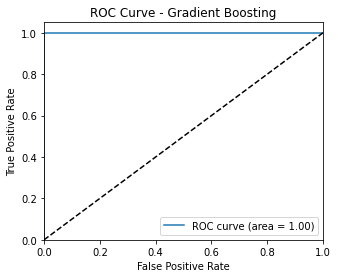

In [84]:
PredAndLabels           = gbt_result_hyper.select("probability", "label")
PredAndLabels_collect   = PredAndLabels.collect()
PredAndLabels_list      = [(float(i[0][0]), 1.0-float(i[1])) for i in PredAndLabels_collect]
PredAndLabels           = sc.parallelize(PredAndLabels_list)

metrics = BinaryClassificationMetrics(PredAndLabels)

# Area under ROC
print("Gradient Boosting Area Under ROC")
print("Area under ROC = %.2f" % metrics.areaUnderROC)

# Visualization
FPR = dict()                                                        # FPR: False Positive Rate
tpr = dict()                                                        # TPR: True Positive Rate
roc_auc = dict()
 
y_test = [i[1] for i in PredAndLabels_list]
y_score = [i[0] for i in PredAndLabels_list]
 
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)
 
plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Gradient Boosting')
plt.legend(loc="lower right")
plt.show()


##### Confusion Matrix

In [85]:
cm_gbt_result_hyper = gbt_result_hyper.crosstab("prediction", "label")
cm_gbt_result_hyper = cm_gbt_result_hyper.toPandas()
cm_gbt_result_hyper

,prediction_label,0,1
0,1.0,0,7433
1,0.0,84403,0


In [86]:
#calculate accuracy, sensitivity, specificity and precision
TP = cm_gbt_result_hyper["1"][0]
FP = cm_gbt_result_hyper["0"][0]
TN = cm_gbt_result_hyper["0"][1]
FN = cm_gbt_result_hyper["1"][1]
Accuracy = (TP+TN)/(TP+FP+TN+FN)
Sensitivity = TP/(TP+FN)
Specificity = TN/(TN+FP)
Precision = TP/(TP+FP)

print ("Accuracy = %0.2f" %Accuracy )
print ("Sensitivity = %0.2f" %Sensitivity )
print ("Specificity = %0.2f" %Specificity )
print ("Precision = %0.2f" %Precision )


Accuracy = 1.00
Sensitivity = 1.00
Specificity = 1.00
Precision = 1.00


##### Calculate Gini Coefficient from AUC

In [87]:
AUC = gbt_hyper_AUC
Gini_gbt_hyper= (2 * AUC -1)

print("AUC=%.2f" % AUC)
print("GINI ~=%.2f" % Gini_gbt_hyper)

AUC=1.00
GINI ~=1.00


##### Calculate Log Loss in pandas dataframe

In [88]:
#Create Dataframe to Calculate Log Loss
y_test= data_test.select('label')
gbt_hyper_proba=gbt_result_hyper.select('probability')


In [89]:
#Convert pyspark dataframe to numpy array
gbt_hyper_proba= np.array(gbt_hyper_proba.select('probability').collect())

#Convert numpy array 3 dimentional to 2 dimentional
gbt_hyper_proba=gbt_hyper_proba.reshape(-1, gbt_hyper_proba.shape[-1])

#Convert y_test dataframe to pandas dataframe
y_test=y_test.toPandas()

#Convert y_test pandas dataframe to pandas series
y_test=pd.Series(y_test['label'].values)


In [90]:
#Calculate log loss from Gradient Boosting hyper parameter
LogLoss = log_loss(y_test, gbt_hyper_proba) 

print("Log Loss Gradient Boosting:%.4f" % LogLoss)


Log Loss Gradient Boosting:0.0681
